In [1]:
import os
import datetime

def timestamp():
    print(datetime.datetime.now().strftime("%b %d %Y, %H:%M:%S"))

# Training

In [1]:
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Trainer

In [2]:
maxsteps=80000

maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"

config = ColBERTConfig(
        bsize=64,
        root=fr"experiments/{experiment}",
        maxsteps=80000,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.train.tsv",
        
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

config

ColBERTConfig(ncells=None, centroid_score_threshold=None, ndocs=None, index_path=None, nbits=1, kmeans_niters=4, resume=False, similarity='cosine', bsize=64, accumsteps=1, lr=3e-06, maxsteps=80000, save_every=None, warmup=None, warmup_bert=None, relu=False, nway=2, use_ib_negatives=False, reranker=False, distillation_alpha=1.0, ignore_scores=False, query_maxlen=32, attend_to_mask_tokens=False, interaction='colbert', dim=128, doc_maxlen=220, mask_punctuation=True, checkpoint=None, triples=None, collection=None, queries=None, index_name=None, overwrite=False, root='experiments\\msmarco_80.000', experiment='msmarco_80.000', index_root=None, name='msmarco_80.000', rank=0, nranks=1, amp=True, gpus=1)

In [3]:
timestamp()
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    trainer = Trainer(
        triples= config.triples,
        queries= config.queries,
        collection= config.collection,
        config=config,
    )

    checkpoint_path = trainer.train()

    print(f"Saved checkpoint to {checkpoint_path}...")
timestamp()

#> Starting...
#> Joined...
Saved checkpoint to None...


# Indexing

In [140]:
import datetime
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer

In [141]:
nbits = 2
maxsteps = 500000
use_iter = 400000

maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"
    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.train.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

In [28]:
timestamp()
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    indexer = Indexer(checkpoint=config.checkpoint, config=config)
    indexer.index(name=config.index_name, collection=config.collection, overwrite=config.overwrite)
timestamp()

Oct 19 2022, 14:18:54


[Oct 19, 14:18:54] #> Creating directory experiments/msmarco_500.000/indexes/msmarco_400.000.nbits=2 


#> Starting...
#> Joined...
Oct 19 2022, 18:44:05


# Retrieval

In [6]:
from colbert.data import Queries
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher

import os

In [7]:
nbits = 2
maxsteps = 500000
use_iter = 400000
k = 1000


maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"

    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.dev.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

In [70]:
timestamp()

with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)
    queries = Queries(config.queries)
    ranking = searcher.search_all(queries, k=k)
    ranking.save(f"msmarco.{use_iter_str}.nbits={config.nbits}.ranking={k}.tsv")
timestamp()

Oct 25 2022, 08:03:36
[Oct 25, 08:03:36] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 
[Oct 25, 08:03:57] #> Loading codec...
[Oct 25, 08:03:57] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Oct 25, 08:04:08] #> Loading IVF...
[Oct 25, 08:04:09] #> Loading doclens...


  0%|          | 0/354 [00:00<?, ?it/s]

[Oct 25, 08:04:10] #> Loading codes and residuals...


  0%|          | 0/354 [00:00<?, ?it/s]

[Oct 25, 08:04:32] #> Loading the queries from ../data/queries.dev.tsv ...
[Oct 25, 08:04:33] #> Got 101093 queries. All QIDs are unique.



  0%|          | 0/101093 [00:00<?, ?it/s]

[Oct 25, 09:25:29] #> Saved ranking of 101093 queries and 101093000 lines to D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\retrieval\msmarco.400.000.nbits=2.ranking=1000.tsv
Oct 25 2022, 09:25:30


# Evaluate

In [9]:
!python -m utility.evaluate.msmarco_passages \
--ranking "experiments/msmarco_{maxsteps_str}/retrieval/msmarco.{use_iter_str}.nbits={config.nbits}.ranking={k}.tsv" \
--qrels "../data/qrels.dev.tsv"

[Oct 25, 09:53:25] #> Loading QRELs from ../data/qrels.dev.tsv ..
#> Reading ../data/qrels.dev.tsv
[Oct 25, 09:53:26] #> Loading ranked lists from experiments/msmarco_500.000/retrieval/msmarco.400.000.nbits=2.ranking=1000.tsv ..
#> Reading experiments/msmarco_500.000/retrieval/msmarco.400.000.nbits=2.ranking=1000.tsv

[Oct 25, 09:56:31] #> [WARNING] num_judged_queries != num_ranked_queries
[Oct 25, 09:56:31] #> 55578 != 101093

[Oct 25, 09:56:31] #> Computing MRR@10 for 55578 queries.

[Oct 25, 09:56:36] #> MRR@10 = 0.3574183458454361
[Oct 25, 09:56:36] #> MRR@10 (only for ranked queries) = 0.19649824246384662


[Oct 25, 09:56:36] #> Recall@50 = 0.807959684287547
[Oct 25, 09:56:36] #> Recall@50 (only for ranked queries) = 0.4441928059641448


[Oct 25, 09:56:36] #> Recall@100 = 0.8597940432065442
[Oct 25, 09:56:36] #> Recall@100 (only for ranked queries) = 0.4726898334536843


[Oct 25, 09:56:36] #> Recall@200 = 0.8958904602540566
[Oct 25, 09:56:36] #> Recall@200 (only for ranked queries


  0%|          | 0/1.1459598541259766 [00:00<?, ?MiB/s]
 67%|######6   | 0.7661161422729492/1.1459598541259766 [00:00<00:00,  7.66MiB/s]
 95%|#########5| 1.089432716369629/1.1459598541259766 [00:00<00:00,  8.64MiB/s] 

  0%|          | 0/2842.183289527893 [00:00<?, ?MiB/s]
  0%|          | 1.422776222229004/2842.183289527893 [00:00<03:20, 14.20MiB/s]
  0%|          | 2.9024124145507812/2842.183289527893 [00:00<03:15, 14.54MiB/s]
  0%|          | 4.493905067443848/2842.183289527893 [00:00<03:07, 15.16MiB/s] 
  0%|          | 6.029884338378906/2842.183289527893 [00:00<03:06, 15.24MiB/s]
  0%|          | 7.579663276672363/2842.183289527893 [00:00<03:04, 15.33MiB/s]
  0%|          | 9.136581420898438/2842.183289527893 [00:00<03:03, 15.40MiB/s]
  0%|          | 10.698785781860352/2842.183289527893 [00:00<03:03, 15.47MiB/s]
  0%|          | 12.24595832824707/2842.183289527893 [00:00<03:03, 15.44MiB/s] 
  0%|          | 13.79030990600586/2842.183289527893 [00:00<03:03, 15.44MiB/s]
  1%|     

# Sparity

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from colbert.modeling.colbert import colbert_score
from colbert.modeling.checkpoint import Checkpoint

In [4]:
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Searcher
import torch
import os
from tqdm.auto import tqdm
from collections import Counter

In [5]:
nbits = 2
maxsteps = 500000
use_iter = 400000


maxsteps_str=f"{maxsteps:,}".replace(',','.')
experiment = f"msmarco_{maxsteps_str}"
base_path = fr"experiments/{experiment}"

use_iter_str=f"{use_iter:,}".replace(',','.')
index_name = f"msmarco_{use_iter_str}.nbits={nbits}"

checkpoint = fr"{base_path}/checkpoints/colbert-{use_iter}" 
if not os.path.exists(checkpoint):
    checkpoint = fr"{base_path}/checkpoints/colbert"

    
config = ColBERTConfig(
        bsize = 64,
        root=base_path,
        experiment=experiment,
        name=experiment,
    
        triples=r"../data/triples.train.small.id.json",
        collection= r"../data/collection.tsv",
        queries= r"../data/queries.dev.tsv",
    
        checkpoint = checkpoint,
        nbits=nbits,
        overwrite='resume',
        index_name=index_name,
        index_path=fr"{base_path}/indexes/{index_name}",
    
        rank = 0,
        nranks = 1,
        amp = True,
        gpus = 1,
    )

## Query

In [11]:
# encode query
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    searcher = Searcher(index=config.index_name, config=config, checkpoint=config.checkpoint)

[Oct 23, 01:09:19] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 
[Oct 23, 01:09:41] #> Loading codec...
[Oct 23, 01:09:41] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
failed to load pytorch extensions
[Oct 23, 01:09:55] #> Loading IVF...
[Oct 23, 01:09:56] #> Loading doclens...


  0%|          | 0/354 [00:00<?, ?it/s]

[Oct 23, 01:09:57] #> Loading codes and residuals...


  0%|          | 0/354 [00:00<?, ?it/s]

In [12]:
life_query_encoded = searcher.encode("What is the meaning of life?")


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What is the meaning of life?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 3574, 1997, 2166, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



In [7]:
life_query_encoded.shape

torch.Size([1, 32, 128])

In [14]:
pids, ranking, scores = searcher.search("what is the meaning of life? google") # from dev: 831190
tuple(zip(pids, ranking, scores))

((1121952, 1, 25.09375),
 (3615892, 2, 24.203125),
 (3974437, 3, 24.171875),
 (3974442, 4, 24.125),
 (8705340, 5, 23.890625),
 (7108187, 6, 23.4375),
 (4158510, 7, 23.3125),
 (342393, 8, 22.890625),
 (3456280, 9, 22.75),
 (2759560, 10, 22.734375))

In [52]:
# pids, ranking, scores = searcher.search("What is the meaning of life?")
pids, ranking, scores = searcher.dense_search(life_query_encoded)
tuple(zip(pids, ranking, scores))

((1121952, 1, 28.609375),
 (3974437, 2, 27.9375),
 (3974442, 3, 27.90625),
 (7108187, 4, 27.8125),
 (4158510, 5, 27.546875),
 (8705340, 6, 27.453125),
 (7981896, 7, 27.078125),
 (4364365, 8, 27.0625),
 (3974443, 9, 26.984375),
 (3615892, 10, 26.921875))

In [54]:
queries = Queries(config.queries)

[Oct 20, 02:53:13] #> Loading the queries from ../data/queries.dev.tsv ...
[Oct 20, 02:53:13] #> Got 101093 queries. All QIDs are unique.



In [57]:
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment, name='retrieval')):
    queries = Queries.cast(queries)
    queries_ = list(queries.values())
    Q = searcher.encode(queries_)

In [78]:
Q.min(), Q.max()

(tensor(-0.4709), tensor(0.4863))

In [61]:
print(Q.shape)
(Q == 0).sum()

torch.Size([101093, 32, 128])


tensor(35)

In [66]:
queries_sparity = (Q == 0).sum(axis=[1,2])

In [76]:
torch.where(queries_sparity == 1)

(tensor([   63,   409,   910,  3426,  5786,  9754, 12746, 13455, 14386, 14932,
         19794, 20071, 20510, 22100, 34237, 36652, 41148, 46133, 49320, 52373,
         56301, 57396, 63487, 66610, 66779, 69646, 69718, 73209, 74591, 80417,
         88581, 90111, 90951, 96014, 99939]),)

In [26]:
# ivf.pid.pt
ivf = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\ivf.pid.pt')
# avg_residual.pt
avg_residual = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\avg_residual.pt')
# bucket_cutoffs, bucket_weights
buckets = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\buckets.pt')
# centroids.pt
centroids = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\centroids.pt')

In [ ]:
civf = Counter(ivf[0])
civf.most_common(50)

In [42]:
ivf[0].max(), ivf[0].min()

(tensor(8841822, dtype=torch.int32), tensor(0, dtype=torch.int32))

In [27]:
ivf[1].shape, ivf[1].sum(), ivf[0]

(torch.Size([262144]),
 tensor(364651202),
 tensor([   7577,   45066,   48549,  ..., 8829501, 8835329, 8835494],
        dtype=torch.int32))

In [29]:
avg_residual

tensor(0.0453, device='cuda:0', dtype=torch.float16)

In [33]:
buckets[0].shape, buckets[1].shape, buckets

(torch.Size([3]),
 torch.Size([4]),
 (tensor([-0.0359,  0.0013,  0.0386], device='cuda:0'),
  tensor([-0.0632, -0.0161,  0.0188,  0.0662], device='cuda:0',
         dtype=torch.float16)))

In [35]:
centroids.shape,centroids

(torch.Size([262144, 128]),
 tensor([[ 0.0015, -0.1648, -0.0179,  ...,  0.0118,  0.0189, -0.0742],
         [ 0.0931, -0.1000, -0.0538,  ...,  0.0629,  0.0190,  0.0513],
         [-0.0494, -0.1044, -0.0089,  ...,  0.0700,  0.0154,  0.0945],
         ...,
         [-0.1100,  0.0224, -0.0762,  ...,  0.0764,  0.0444,  0.0469],
         [ 0.1238, -0.0312, -0.0622,  ...,  0.0558,  0.1153,  0.0131],
         [-0.0138, -0.0814,  0.0240,  ...,  0.0692,  0.1039,  0.1116]],
        device='cuda:0', dtype=torch.float16))

In [11]:
codes

tensor([ 56105,  26028, 256077,  ...,  25332, 149415, 165404],
       dtype=torch.int32)

In [9]:
codes = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\0.codes.pt')
residuals = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\0.residuals.pt')
codes.shape, residuals.shape

(torch.Size([1598526]), torch.Size([1598526, 32]))

In [14]:
codes[35:50]

tensor([147527, 147527, 167310,  90353, 140991, 153035,  90353,  85945,   3465,
         22579, 147527,   3465, 232712, 147527, 115957], dtype=torch.int32)

In [15]:
residuals[35:37]

tensor([[ 79, 120,  89,  16, 182, 205,  37,  56, 125, 156, 208, 154,  23,  85,
         220, 244, 135,  79, 117,  71, 178,  50, 136, 176, 115, 242, 223,  99,
          32,   2, 211, 115],
        [238, 116,  88, 176, 244, 201,  20,  16, 188, 108, 208, 148, 147,  85,
         206, 254,  23, 237, 125,  15, 181,  51, 128, 120, 251, 248, 207,  91,
          48,  98,  96,  99]], dtype=torch.uint8)

In [10]:
codes = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\1.codes.pt')
residuals = torch.load(r'D:\Documents\Python_Scripts\class\UCB\splade-colBERT\ColBERT\experiments\msmarco_500.000\indexes\msmarco_400.000.nbits=2\1.residuals.pt')
codes.shape, residuals.shape

(torch.Size([1607532]), torch.Size([1607532, 32]))

In [114]:
life_query_encoded.shape

torch.Size([1, 32, 128])

In [121]:
# Q = life_query_encoded
# searcher.ranker.rank(searcher.config, life_query_encoded)
centroid_pids, centroid_scores = searcher.ranker.retrieve(searcher.config, life_query_encoded)

In [122]:
centroid_pids.shape, centroid_scores.shape

(torch.Size([13902]), torch.Size([262144, 32]))

In [123]:
centroid_pids, centroid_scores

(tensor([    396,    1728,    2501,  ..., 8840790, 8841657, 8841660],
        device='cuda:0', dtype=torch.int32),
 tensor([[-0.1378, -0.1649, -0.1375,  ..., -0.1434, -0.1785, -0.1752],
         [-0.0378, -0.0491, -0.0577,  ..., -0.0178,  0.0151, -0.1091],
         [-0.0823, -0.0868, -0.0883,  ..., -0.1517, -0.1335, -0.1893],
         ...,
         [ 0.2952,  0.2732,  0.2473,  ...,  0.2493,  0.2830,  0.2952],
         [-0.0795, -0.0845, -0.0806,  ..., -0.0792, -0.0663, -0.1605],
         [-0.1785, -0.1891, -0.1603,  ..., -0.2695, -0.2463, -0.2900]],
        device='cuda:0', dtype=torch.float16))

In [127]:
scores, pids = searcher.ranker.score_pids(searcher.config, life_query_encoded, centroid_pids, centroid_scores)

In [135]:
pids.shape, scores.shape

(torch.Size([64]), torch.Size([64]))

In [136]:
pids, scores

(tensor([3974445, 3974443, 3974437, 3974442,  259573, 1121950,  192804, 4364369,
         3456280, 2224639, 7038478, 4438518, 3974438, 5946742,  541681, 7948431,
         6127439, 1224927, 1121952, 6530069, 2759560,  127242, 8705340, 5526886,
         5694093, 6530075, 1122371, 7981896, 1412741, 1320434, 5505423, 5335825,
         5128533, 4686520,  918364, 7132968, 3615892, 3841642, 7108187, 8330535,
         7107097, 4158510, 1332439, 4364365, 5391348,  342393, 5001980, 1354966,
         2097107, 5838560, 4842540, 4778257,   52333,  266319,  505569, 1626388,
          475641,  474364, 8433246, 1354970, 5528307, 8671004,  907345, 7586350],
        device='cuda:0', dtype=torch.int32),
 tensor([26.3281, 26.9844, 27.9375, 27.9062, 24.3438, 26.2812, 23.4844, 26.1562,
         26.0781, 22.4375, 23.4844, 25.7500, 26.7188, 25.7344, 26.1250, 21.6406,
         24.7188, 21.7344, 28.6094, 21.0312, 26.3125, 24.3125, 27.4531, 26.1094,
         24.5000, 24.2656, 26.2344, 27.0781, 21.3906, 23.0938, 

## Collection

In [16]:
with Run().context(RunConfig(nranks=config.nranks, experiment=config.experiment)):
    checkpoint = Checkpoint(config.checkpoint, colbert_config=config)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
checkpoint.to(device)
checkpoint.device

device(type='cuda', index=0)

In [15]:
searcher.collection[1121952]

'The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.'

In [85]:
passages_batch = [
    searcher.collection[1121952],
    searcher.collection[3974437],
    searcher.collection[3974442],
    searcher.collection[7108187],
    searcher.collection[4158510],
    searcher.collection[8705340],
    searcher.collection[7981896],
    searcher.collection[4364365],
    searcher.collection[3974443],
    searcher.collection[3615892],
]*1
encoded_doc = checkpoint.docFromText(passages_batch)
encoded_doc.shape

torch.Size([10, 91, 128])

In [49]:
encoded_doc[0]

tensor([[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
        [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
        [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       dtype=torch.float16)

In [ ]:
encoded_doc

In [86]:
embs_, doclens_, tokens_ = checkpoint.docFromText(
    passages_batch, bsize=64, keep_dims='flatten', return_tokens=True
)

In [87]:
doclens_

[47, 39, 23, 50, 54, 53, 54, 75, 62, 74]

In [82]:
embs_

tensor([[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
        [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
        [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
        ...,
        [ 0.0286, -0.0302, -0.1038,  ..., -0.0053, -0.0471,  0.0421],
        [ 0.0381, -0.0270, -0.0923,  ...,  0.0624, -0.1322,  0.1174],
        [ 0.0811, -0.0252,  0.0536,  ...,  0.0424, -0.0372,  0.1010]],
       dtype=torch.float16)

In [33]:
v = set(tokens_[0].tolist())
for _ in range(10):
    v = v.intersection(tokens_[1].tolist()).intersection(tokens_[2].tolist())

In [37]:
checkpoint.doc_tokenizer.tok.decode(list(v))

'[PAD] [unused1] your [CLS] [SEP] gift away give the of purpose to is. life meaning find it'

In [71]:
searcher.collection[1121952],

('The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.',)

In [95]:
text_batches, reverse_indices = checkpoint.doc_tokenizer.tensorize(['The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.'], bsize=64)

In [96]:
text_batches

[(tensor([[  101,     2,  1996,  3574,  1997,  2166,  2003,  2000,  2424,  2115,
            5592,  1012,  1996,  3800,  1997,  2166,  2003,  2000,  2507,  2009,
            2185,  1012,  2023,  4861,  2003,  2411,  7108,  2000,  1996, 15607,
           11170,  2520,  8101,  2030,  1996,  6383,  5276, 11623, 22457,  2006,
            2591,  6125,  2066,  9130,  1998,  9231,  3334,  4355,  1012,   102]]),
  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1]]))]

In [100]:
keep_dims_ = 'return_mask'
batches = [checkpoint.doc(input_ids, attention_mask, keep_dims=keep_dims_, to_cpu=False)
           for input_ids, attention_mask in tqdm(text_batches, disable=True)]

In [115]:
len(~batches[0][1].flatten())

50

In [ ]:
tokens_

In [47]:
[t.count_nonzero() for t in tokens_]

[tensor(50),
 tensor(47),
 tensor(26),
 tensor(54),
 tensor(68),
 tensor(57),
 tensor(63),
 tensor(91),
 tensor(68),
 tensor(85)]

In [35]:
doclens_

[47, 39, 23, 50, 54, 53, 54, 75, 62, 74]

In [19]:
embs_.shape

torch.Size([47, 128])

In [29]:
encoded_doc.min(), encoded_doc.max()

(tensor(-0.3762, dtype=torch.float16), tensor(0.3491, dtype=torch.float16))

In [105]:
print(encoded_doc.shape)
(encoded_doc == 0).sum(1)

torch.Size([10, 91, 128])


tensor([[44, 44, 44,  ..., 44, 44, 44],
        [52, 52, 52,  ..., 52, 52, 52],
        [68, 68, 68,  ..., 68, 68, 68],
        ...,
        [16, 16, 16,  ..., 16, 16, 16],
        [29, 29, 29,  ..., 29, 29, 29],
        [17, 17, 17,  ..., 17, 17, 17]])

In [32]:
encoded_doc.shape

torch.Size([10, 91, 128])

In [31]:
colbert_score(life_query_encoded, encoded_doc, doc_mask)

RuntimeError: shape '[10, 91]' is invalid for input of size 50

In [15]:
encoded_doc.cuda()

tensor([[[ 0.0035,  0.0086, -0.0008,  ..., -0.0293, -0.0570,  0.1171],
         [ 0.0269,  0.0225,  0.0171,  ...,  0.0581, -0.0572,  0.1011],
         [ 0.0196,  0.0066, -0.0181,  ...,  0.0019, -0.0530,  0.1140],
         ...,
         [-0.0976, -0.0024,  0.0620,  ...,  0.0011,  0.0368,  0.0638],
         [-0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [ 0.0233, -0.0207,  0.0698,  ...,  0.0863, -0.0249,  0.1903]]],
       device='cuda:0', dtype=torch.float16)

In [16]:
scores = encoded_doc.cuda() @ life_query_encoded.to(encoded_doc.dtype).permute(0,2,1)

In [21]:
scores.shape

torch.Size([1, 50, 32])

In [12]:
doc_mask = torch.ones(encoded_doc.shape[:2])

In [22]:
D_padding = ~doc_mask.view(scores.size(0), scores.size(1)).bool()
scores[D_padding] = -9999
scores.max(1).values.sum(-1)

tensor([28.9688], device='cuda:0', dtype=torch.float16)

In [24]:
max_scores = scores.max(1).values
max_scores.shape

torch.Size([1, 32])

In [25]:
max_scores.sum(-1)

tensor([28.9688], device='cuda:0', dtype=torch.float16)

## Get posting list and value distribution

In [26]:
from colbert.indexing.collection_encoder import CollectionEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [27]:
from colbert.data import Collection
collection = Collection.cast(config.collection)

[Oct 25, 16:15:22] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 


In [28]:
for x in [1121952, 3615892, 3974437]:
    print(collection[x])
    print()

The meaning of life is to find your gift. The purpose of life is to give it away. This statement is often attributed to the famed playwright William Shakespeare or the influential painter Pablo Picasso on social networks like Facebook and Pinterest.

life noun. A1 [C or U] the âperiod between âbirth and âdeath, or the âexperience or âstate of being âalive: Life's too âshort to âworry about âmoney! I'm not âsure I âwant to âspend the ârest of my life with him. Unfortunately, âaccidents are âpart of life.

Unknown quotes. The meaning of life is to find your gift, the purpose of life is to give it away. 27 up, 2 down. favorite. Comment. Share your thoughts on what this quote means to you.



### BERT-Token Posting List

In [11]:
batches = collection.enumerate_batches(rank=config.rank)

In [12]:
checkpoint.doc_tokenizer.tok.vocab_size

30522

In [20]:
checkpoint.doc_tokenizer.tok.convert_tokens_to_ids('[unused1]')

2

In [24]:
checkpoint.doc_tokenizer.tok.convert_ids_to_tokens(101)

'[CLS]'

In [220]:
inverted_index = defaultdict(list)

for chunk_idx, offset, passages in tqdm(batches, disable=config.rank > 0):
    text_batches, reverse_indices = checkpoint.doc_tokenizer.tensorize(passages, bsize=config.bsize)

    returned_text = [text for batch in text_batches for text in batch[0]]
    returned_text = [returned_text[idx] for idx in reverse_indices.tolist()]
    for chunk_loc_idx, token_id_list in enumerate(returned_text):
        cur_pid = chunk_loc_idx+offset
        for token_id in token_id_list.tolist():
            inverted_index[token_id].append(cur_pid)
            if token_id == 102: break
    print("[{}] {}".format(datetime.datetime.now().strftime("%b %d, %H:%M:%S"), chunk_idx))

0it [00:00, ?it/s]

[Oct 23, 16:15:40] 0
[Oct 23, 16:15:43] 1
[Oct 23, 16:15:47] 2
[Oct 23, 16:15:50] 3
[Oct 23, 16:15:53] 4
[Oct 23, 16:15:57] 5
[Oct 23, 16:16:00] 6
[Oct 23, 16:16:03] 7
[Oct 23, 16:16:07] 8
[Oct 23, 16:16:10] 9
[Oct 23, 16:16:13] 10
[Oct 23, 16:16:16] 11
[Oct 23, 16:16:20] 12
[Oct 23, 16:16:23] 13
[Oct 23, 16:16:27] 14
[Oct 23, 16:16:30] 15
[Oct 23, 16:16:33] 16
[Oct 23, 16:16:37] 17
[Oct 23, 16:16:40] 18
[Oct 23, 16:16:43] 19
[Oct 23, 16:16:47] 20
[Oct 23, 16:16:50] 21
[Oct 23, 16:16:54] 22
[Oct 23, 16:16:57] 23
[Oct 23, 16:17:01] 24
[Oct 23, 16:17:04] 25
[Oct 23, 16:17:08] 26
[Oct 23, 16:17:11] 27
[Oct 23, 16:17:15] 28
[Oct 23, 16:17:19] 29
[Oct 23, 16:17:23] 30
[Oct 23, 16:17:27] 31
[Oct 23, 16:17:31] 32
[Oct 23, 16:17:34] 33
[Oct 23, 16:17:39] 34
[Oct 23, 16:17:43] 35
[Oct 23, 16:17:47] 36
[Oct 23, 16:17:51] 37
[Oct 23, 16:17:55] 38
[Oct 23, 16:18:00] 39
[Oct 23, 16:18:04] 40
[Oct 23, 16:18:08] 41
[Oct 23, 16:18:12] 42
[Oct 23, 16:18:17] 43
[Oct 23, 16:18:21] 44
[Oct 23, 16:18:26] 4

In [223]:
count_ii = {k:len(v) for k,v in inverted_index.items()}

(1, 36124477)

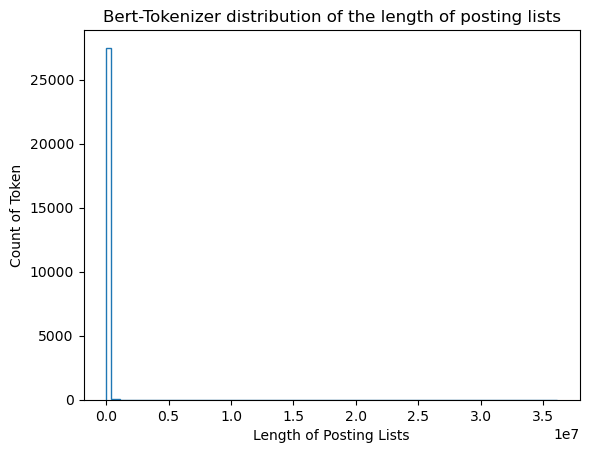

In [351]:
plt.title(r'Bert-Tokenizer distribution of the length of posting lists')
plt.xlabel('Length of Posting Lists')
plt.ylabel('Count of Token')
plt.hist(count_ii.values(), bins=100, histtype='step');

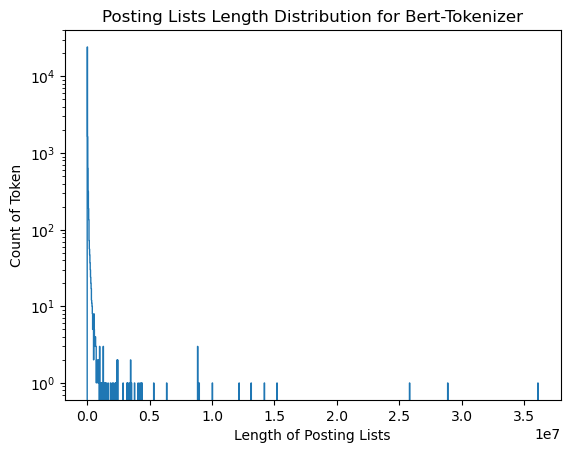

In [374]:
plt.title(r'Posting Lists Length Distribution for Bert-Tokenizer')
plt.xlabel('Length of Posting Lists')
plt.ylabel('Count of Token')
plt.hist(count_ii.values(), bins=1500, histtype='step', log=True);

### ColBERT Representation

In [22]:
batches = collection.enumerate_batches(rank=config.rank)

In [12]:
collection_encoder = CollectionEncoder(config, checkpoint)

In [ ]:
embs_counter = Counter()
doclens_counter = Counter()
for chunk_idx, offset, passages in tqdm(batches, disable=config.rank > 0):
    embs, doclens = collection_encoder.encode_passages(passages)
    print("\rupdating len ", end='')
    doclens_counter.update(doclens)
    print("\rupdating emb ", end='')
    embs_counter.update(list(embs.flatten().detach().numpy().astype('float32').round(6)))
    print(f"\r{chunk_idx}: {len(embs_counter)} {len(doclens_counter)} {' '*10}")

0it [00:00, ?it/s]

[Oct 24, 14:11:26] [0] 		 #> Encoding 25000 passages..
updating emb 0: 19688 184
[Oct 24, 14:12:40] [0] 		 #> Encoding 25000 passages..
updating emb 1: 19790 191
[Oct 24, 14:13:55] [0] 		 #> Encoding 25000 passages..
updating emb 2: 19823 196
[Oct 24, 14:15:10] [0] 		 #> Encoding 25000 passages..
updating emb 3: 19866 197
[Oct 24, 14:16:26] [0] 		 #> Encoding 25000 passages..
updating emb 4: 19889 198
[Oct 24, 14:17:41] [0] 		 #> Encoding 25000 passages..
updating emb 5: 19903 200
[Oct 24, 14:18:55] [0] 		 #> Encoding 25000 passages..
updating emb 6: 19927 200
[Oct 24, 14:20:08] [0] 		 #> Encoding 25000 passages..
updating emb 7: 19937 201
[Oct 24, 14:21:21] [0] 		 #> Encoding 25000 passages..
updating emb 8: 19950 201
[Oct 24, 14:22:33] [0] 		 #> Encoding 25000 passages..
updating emb 9: 19954 201
[Oct 24, 14:23:46] [0] 		 #> Encoding 25000 passages..
updating emb 10: 19964 202
[Oct 24, 14:25:01] [0] 		 #> Encoding 25000 passages..
updating emb 11: 19988 203
[Oct 24, 14:26:14] [0] 		 

In [48]:
import ujson
index_file = '../data/ColBERT_v1_dense_count.json'
with open(index_file, 'w') as f:
    ujson.dump(dict(embs_counter), f)

In [30]:
avg_doclen = np.average(list(doclens_counter.keys()), weights=list(doclens_counter.values()))
avg_doclen

67.60597786225759

In [51]:
sorted_doclens = sorted(doclens_counter.items())
sorted_doclens = np.array(sorted_doclens)

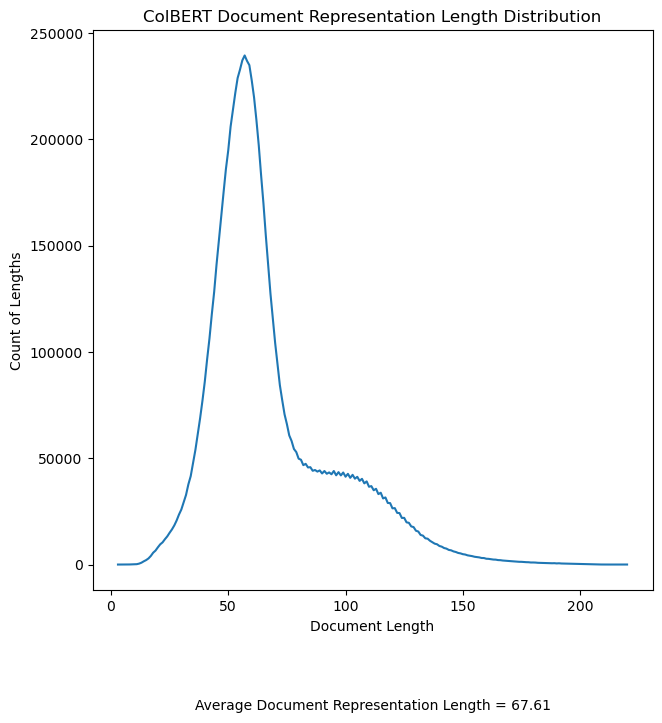

In [66]:
hist_x = 'Document Length'
hist_y = 'Count of Lengths'

additional_text = f"Average Document Representation Length = {avg_doclen:.2f}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Document Representation Length Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
plt.plot(sorted_doclens[:,0], sorted_doclens[:,1])
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

In [ ]:
sorted_dr = sorted(embs_counter.items())
sorted_dr = np.array(sorted_dr)

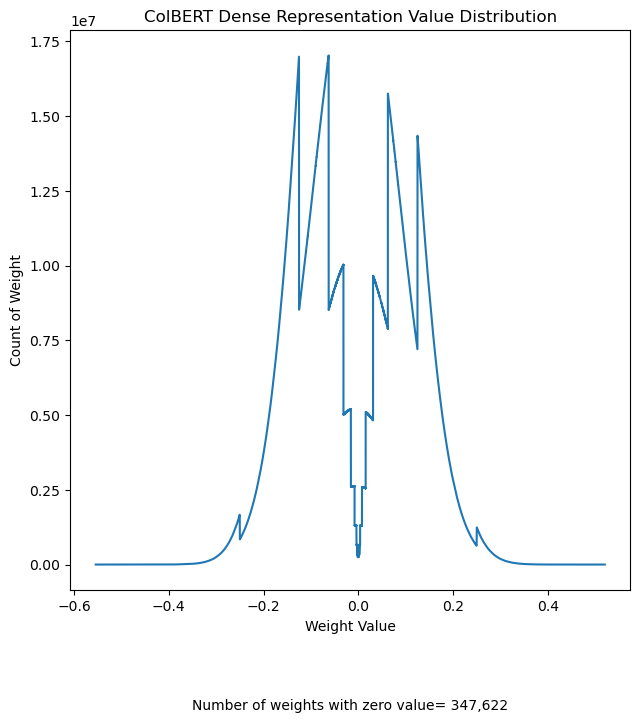

In [67]:
hist_x = 'Weight Value'
hist_y = 'Count of Weight'

additional_text = f"Number of weights with zero value= {embs_counter[0]:3,}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Dense Representation Value Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
plt.plot(sorted_dr[:,0], sorted_dr[:,1])
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

### Get Model Weights

In [324]:
model_weights = defaultdict(list)
for name, param in tqdm(checkpoint.named_parameters()):
    if not name.endswith('weight') \
        or 'LayerNorm' in name \
        or name.startswith('model.bert.embeddings') \
        or name.startswith('model.bert.pooler'): 
            continue
    s_name = name.split('.')
    if s_name[1] == 'bert':
        clean_name = ".".join(s_name[5:])
    else:
        clean_name = ".".join(s_name[1:])
    # print(clean_name, ":" ,param.shape)
    model_weights[clean_name] += param.round(decimals=6).detach().numpy().flatten().tolist()

0it [00:00, ?it/s]

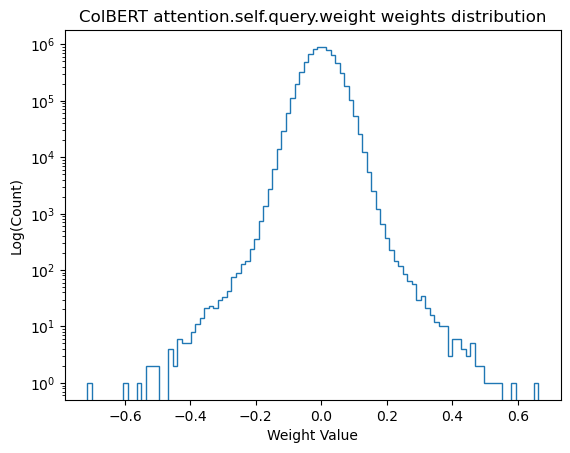

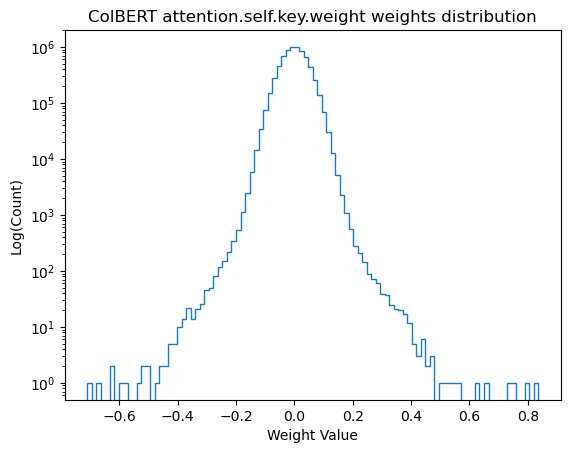

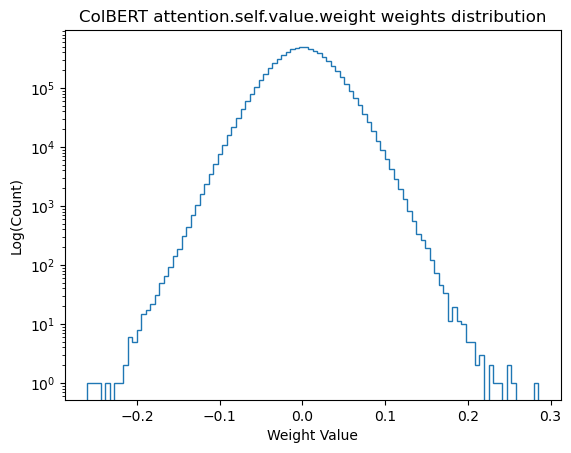

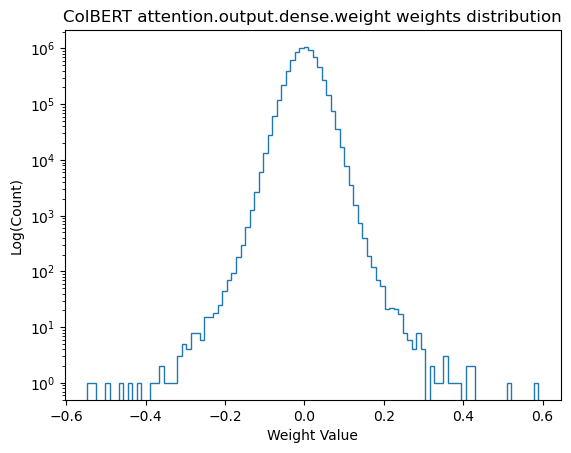

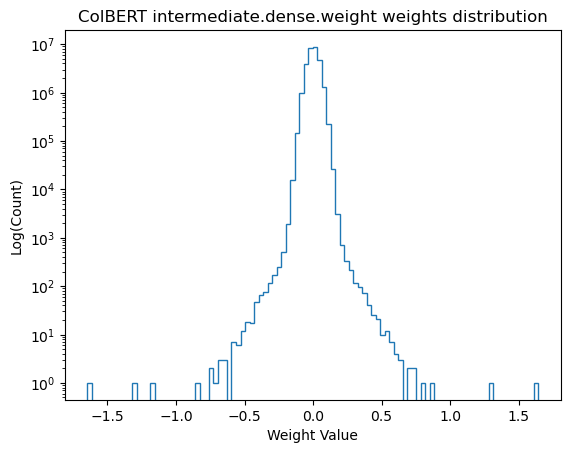

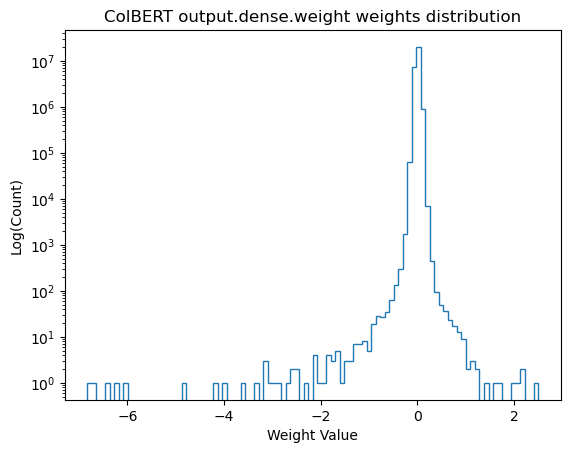

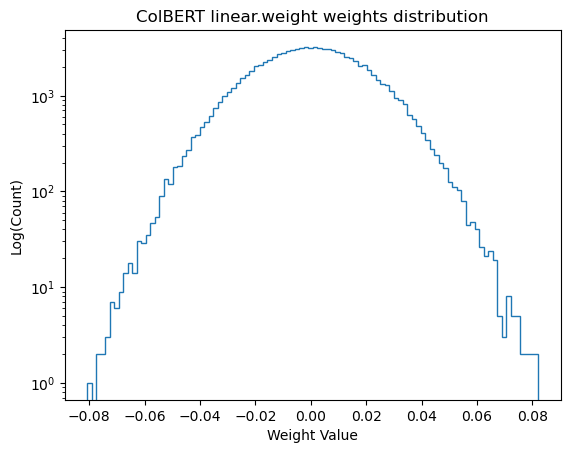

In [326]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'
for name, weights in model_weights.items():
    plt.title(f'ColBERT {name} Distribution')
    
    plt.xlabel(f'{hist_x}')
    
    ylabel = f'Log({hist_y})' if use_hist_log else f'{hist_y}'
    plt.ylabel(ylabel)
    plt.hist(weights, bins=100, histtype='step', log=True);
    plt.show()

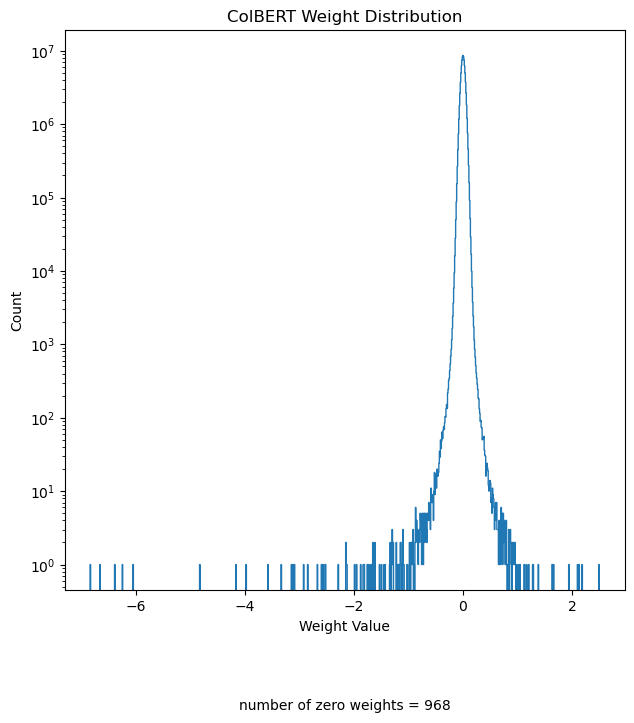

In [384]:
use_hist_log = True
hist_x = 'Weight Value'
hist_y = 'Count'

all_weights = []
for name, weights in model_weights.items():
    all_weights += weights


additional_text = f"number of zero weights = {(np.array(all_weights)==0).sum()}"
    
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(f'ColBERT Weight Distribution')
ax1.set_xlabel(f'{hist_x}')
ax1.set_ylabel(f'{hist_y}')
ax1.hist(all_weights, bins=1000, histtype='step', log=True);
fig.text(.5, .05, additional_text, ha='center')
fig.set_size_inches(7, 8, forward=True)
plt.show()

# New Section

# Adjust MS-MARCO

In [2]:
from colbert.evaluation.loaders import *

In [3]:
from tqdm.auto import tqdm

In [15]:
param = {
    'triples': '../data/triples.train.small.tsv',
    'queries': '../data/queries.train.tsv',
    'collection': '../data/collection.tsv'
}

In [ ]:
def load_queries(queries_path):
    queries = OrderedDict()

    print_message("#> Loading the queries from", queries_path, "...")

    with open(queries_path, encoding='utf-8') as f:
        for line in f:
            qid, query, *_ = line.replace("\xa0", " ").strip().split('\t')
            qid = int(qid)

            assert (qid not in queries), ("Query QID", qid, "is repeated!")
            queries[re.sub('[^ 0-9a-zA-Z_-]', '', query.strip(" "))] = qid

    print_message("#> Got", len(queries), "queries. All QIDs are unique.\n")

    return queries

In [ ]:
def load_collection(collection_path):
    print_message("#> Loading collection...")

    collection = {}

    with open(collection_path, encoding="utf-8") as f:
        for line_idx, line in enumerate(f):
            if line_idx % (1000*1000) == 0:
                print(f'{line_idx // 1000 // 1000}M', end=' ', flush=True)

            pid, passage, *rest = line.strip('\n\r ').split('\t')
            assert pid == 'id' or int(pid) == line_idx

            if len(rest) >= 1:
                title = rest[0]
                passage = title + ' | ' + passage

            collection[passage] = line_idx

    print()

    return collection

In [ ]:
import re

In [ ]:
queries = load_queries(param['queries'])

[Sep 26, 18:41:38] #> Loading the queries from ../data/queries.train.tsv ...
[Sep 26, 18:41:39] #> Got 806349 queries. All QIDs are unique.



In [ ]:
collection = load_collection(param['collection'])

[Sep 26, 18:41:39] #> Loading collection...
0M 1M 2M 3M 4M 5M 6M 7M 8M 


In [ ]:
global err_text
err_text = ""
def get_id(text, data):
    err_text = text
    _id = data.get(exceptions.get(text, text), None)
    if _id is None: 
        text = text.replace("\xa0",' ')
        _id = data.get(exceptions.get(text, text), None)
    if _id is None: 
        n_text = text.strip(' ')
        _id = data.get(exceptions.get(n_text, n_text), None)
    if _id is None: 
        n_text = re.sub('[^ 0-9a-zA-Z_-]', '', n_text)
        _id = data.get(exceptions.get(n_text, n_text), None)
    if _id is None: 
        _id = data.get(text.strip(' '), None)
    
    if _id is None:
        print(text)
        raise Exception(text)
    return _id

In [ ]:
exceptions = {'divorce et sÃ©paration': 'divorce et séparation',
 'what is intelÂ® vpro technology': 'what is intel® vpro technology',
 'what is aÂ\xa0shock wave': 'what is a shock wave',
 'Germanyâ\x80\x99s perspective, the Treaty of Versailles was a fair settlement for its national interests': 'Germany’s perspective, the Treaty of Versailles was a fair settlement for its national interests',
 'yesÃ¼n temÃ¼r khan emperor taiding of yuan': 'yesün temür khan emperor taiding of yuan',
 ' The vitamin that prevents beriberi is ': ' The vitamin that prevents beriberi is',
 ' phosphates as food ingredients ': ' phosphates as food ingredients',
 ' who invented the periodic table ': ' who invented the periodic table',
 'what does bokmÃ¥l mean': 'what does bokmål mean',
 'which action should youÂ\xa0never take when selecting quotations': 'which action should you never take when selecting quotations',
 'dermatitis, anemia, convulsions, depressions, and confusion are all signs of a vitamin _________Â\xa0deficiency.': 'dermatitis anemia convulsions depressions and confusion are all signs of a vitamin _________ deficiency',
 ' In humans, the normal set point for body temperature is ': 'In humans the normal set point for body temperature is',
 'what did you notice about the relationship between pressure and volume when the temperatureÂ\xa0 is held constant?': 'what did you notice about the relationship between pressure and volume when the temperature  is held constant',
 'the Â\xa0____________Â\xa0 that vibrates like a drum when sound waves hit.': 'the  ____________  that vibrates like a drum when sound waves hit',
 'what is composition?Â\xa0 why is composition important?': 'what is composition  why is composition important',
 'the lithosphere consists of Â\xa0____________': 'the lithosphere consists of  ____________',
 "what is a 'cost engineer ": 'what is a cost engineer',
 'A simple way to save with a competitive interest rate. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. Just deposit your savings and watch it grow. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. ': 'A simple way to save with a competitive interest rate. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0. Just deposit your savings and watch it grow. Your Personal Savings account earns interest daily and is posted to your account monthly. You can easily set up recurring transfers from your current bank accounts to your Personal Savings account.â\x80\xa0.',
 "Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir ": "Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir",
 "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir ": "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir"}

In [ ]:
examples = []
with open(param['triples'], encoding='utf-8') as f:
    for line in tqdm(f):
        q_str, p_str_p, p_str_n = line.strip('\n').split('\t')
        qid = get_id(q_str, queries)
        pid_p = get_id(p_str_p, collection)
        pid_n = get_id(p_str_n, collection)
        example = [qid, pid_p, pid_n]
        examples.append(example)

0it [00:00, ?it/s]

In [ ]:
id_file = '../data/triples.train.small.id.json'
    
with open(id_file, 'w') as f:
    for example in examples:
        ujson.dump(example, f)
        f.write('\n')

output_path = f.name
print_message(f"#> Saved examples with {len(self.data)} lines to {f.name}")

NameError: name 'self' is not defined

In [ ]:
id_file = '../data/triples.train.small.id.tsv'
with open(id_file, 'r') as f:
    id_examples = ujson.load(f)

In [ ]:
len(id_examples)
len(id_examples[0])

In [ ]:
data = collection
# data = queries
qid = [k for k in data.keys() if "lamic Laws are made up of Shar" in k]
qid

["Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sira. Islamic jurisprudence is a complimentary expansion of the former by Islamic juris efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir",
 "Definition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø© Å\xa0arÄ«Ê¿ah) and Islamic jurisprudence (Ù\x81Ù\x82Ù\x87â\x80\x8e Fiqh). Shari'ah is seen as sacred and constitutes the Qur'an and Prophet Muhammad 's Sunnah (way), which is found in the Hadith and Sir efinition [edit]. Islamic Laws are made up of Shari'ah ('â\x80\x8eØ´Ø±Ù\x8aØ¹Ø

In [304]:
exceptions = {**exceptions, **{p_str_n: qid[1]}}
exceptions

{'divorce et sÃ©paration': 'divorce et séparation',
 'what is intelÂ® vpro technology': 'what is intel® vpro technology',
 'what is aÂ\xa0shock wave': 'what is a shock wave',
 'Germanyâ\x80\x99s perspective, the Treaty of Versailles was a fair settlement for its national interests': 'Germany’s perspective, the Treaty of Versailles was a fair settlement for its national interests',
 'yesÃ¼n temÃ¼r khan emperor taiding of yuan': 'yesün temür khan emperor taiding of yuan',
 ' The vitamin that prevents beriberi is ': ' The vitamin that prevents beriberi is',
 ' phosphates as food ingredients ': ' phosphates as food ingredients',
 ' who invented the periodic table ': ' who invented the periodic table',
 'what does bokmÃ¥l mean': 'what does bokmål mean',
 'which action should youÂ\xa0never take when selecting quotations': 'which action should you never take when selecting quotations',
 'dermatitis, anemia, convulsions, depressions, and confusion are all signs of a vitamin _________Â\xa0defic